3652
First round:0.6818851251840943
C=0.01,score=0.5235640648011782
C=0.1,score=0.6553755522827688
C=1,score=0.6818851251840943
C=10,score=0.6737849779086893
C=100,score=0.6620029455081001
First round: 0.6715758468335787
C=0.01,score=0.6649484536082474
C=0.1,score=0.7017673048600883
C=1,score=0.6715758468335787
C=10,score=0.6303387334315169


/opt/homebrew/lib/python3.9/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


C=100,score=0.5927835051546392
0.6686303387334315
0.6399116347569955


FileNotFoundError: [Errno 2] No such file or directory: 'data/yum_ingr.pkl'

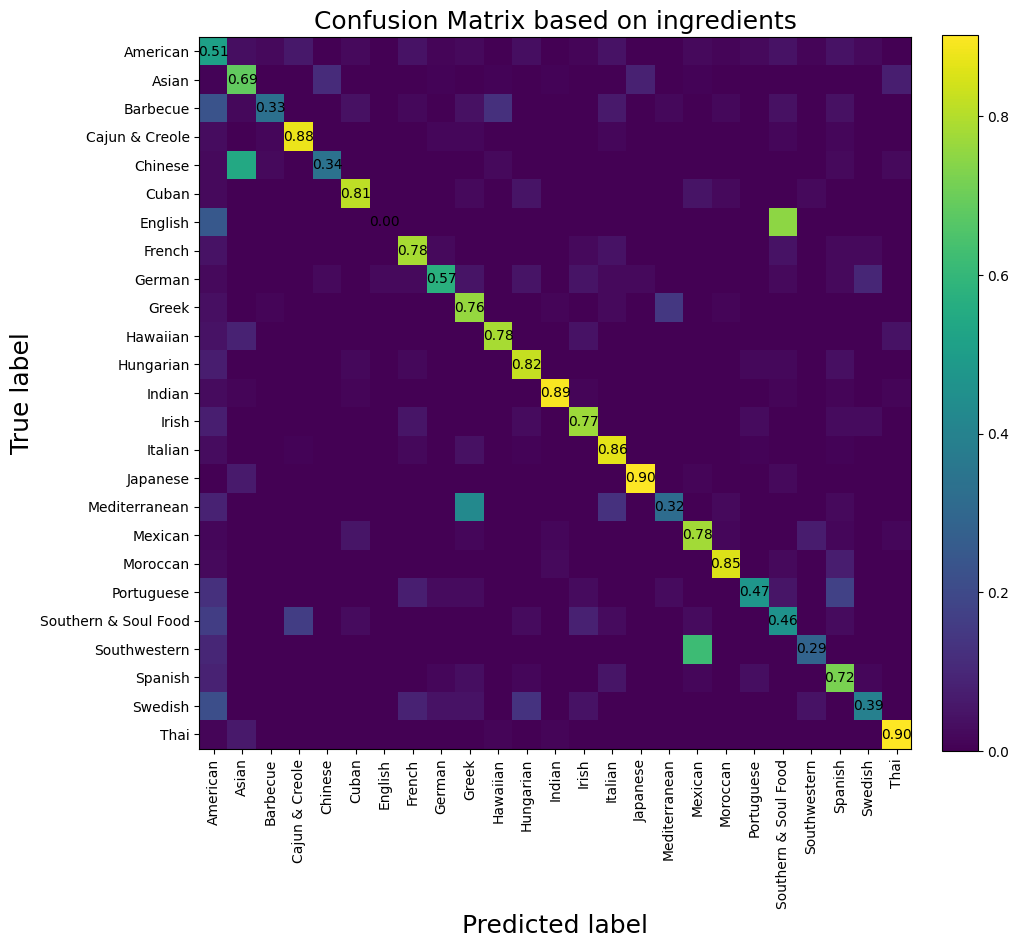

In [3]:
'''Classify recipes into regional cuisines based on ingredients or flavors, using logistic regresion, SVM, randomforest, MultinomialNB, and plot confusion_matrix
'''
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.show()

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import KFold, train_test_split,  GridSearchCV
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report

def logistic_test(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=10)
    model = LogisticRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print('First round:'+ str(metrics.accuracy_score(y_test,y_pred)))
    #tune parameter C
    crange =[0.01,0.1,1,10,100]
    for num in crange:
        model = LogisticRegression(C=num)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        print ('C='+ str(num)+ ',score='+ str(metrics.accuracy_score(y_test,y_pred)))

def svm_test(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=10)
    model = svm.LinearSVC(C=1)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print( 'First round:', str(metrics.accuracy_score(y_test,y_pred)))
    #tune parameter C
    crange =[0.01,0.1,1,10,100]
    for num in crange:
        model = svm.LinearSVC(C=num)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        print ('C='+ str(num)+',score=' + str(metrics.accuracy_score(y_test,y_pred)))

def nb_test(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=1)
    model = MultinomialNB()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print (metrics.accuracy_score(y_test,y_pred))

def rf_test(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=10)
    rf_model = RandomForestClassifier(n_estimators = 100, n_jobs=-1)
    rf_model.fit(X_train, y_train)
    y_pred = rf_model.predict(X_test)
    print (metrics.accuracy_score(y_test,y_pred))

#plot confusion_matrix, 'col' is the y target
def plot_confusion_matrix(cm, col, title, cmap=plt.cm.viridis):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    for i in range(cm.shape[0]):
        plt.annotate("%.2f" %cm[i][i],xy=(i,i),
                    horizontalalignment='center',
                    verticalalignment='center')
    plt.title(title,fontsize=18)
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(col.unique()))
    plt.xticks(tick_marks, sorted(col.unique()),rotation=90)
    plt.yticks(tick_marks, sorted(col.unique()))
    plt.tight_layout()
    plt.ylabel('True label',fontsize=18)
    plt.xlabel('Predicted label',fontsize=18)

#using flavor network to project recipes from ingredient matrix to flavor matrix
def flavor_profile(df,ingr,comp,ingr_comp):
    sorted_ingredients = df.columns
    underscore_ingredients=[]
    for item in sorted_ingredients:
        underscore_ingredients.append(item.replace(' ','_'))

    print (len(underscore_ingredients)+ len(sorted_ingredients))

    ingr_total = ingr_comp.join(ingr,how='right',on='# ingredient id')
    ingr_total = ingr_total.join(comp,how='right',on='compound id')

    ingr_pivot = pd.crosstab(ingr_total['ingredient name'],ingr_total['compound id'])
    ingr_flavor = ingr_pivot[ingr_pivot.index.isin(underscore_ingredients)]

    df_flavor = df.values.dot(ingr_flavor.values)
    print (df.shape + df_flavor.shape)

    return df_flavor

#normalize flavor matrix with tfidf method
def make_tfidf(arr):
    '''input, numpy array with flavor counts for each recipe and compounds
    return numpy array adjusted as tfidf
    '''
    arr2 = arr.copy()
    N=arr2.shape[0]
    l2_rows = np.sqrt(np.sum(arr2**2, axis=1)).reshape(N, 1)
    l2_rows[l2_rows==0]=1
    arr2_norm = arr2/l2_rows

    arr2_freq = np.sum(arr2_norm>0, axis=0)
    arr2_idf = np.log(float(N+1) / (1.0 + arr2_freq)) + 1.0

    from sklearn.preprocessing import normalize
    tfidf = np.multiply(arr2_norm, arr2_idf)
    tfidf = normalize(tfidf, norm='l2', axis=1)
    print (tfidf.shape)
    return tfidf


if __name__ == '__main__':
    #read pickled dataframe
    yum_clean = pd.read_pickle('data/yummly_clean.pkl')

    #create a set of all ingredients in the dataframe
    yum_ingredients=set()
    yum_clean['clean ingredients'].map(lambda x: [yum_ingredients.add(i) for i in x])
    print (len(yum_ingredients))
    #create one column for each ingredient, True or False
    yum = yum_clean.copy()
    # for item in yum_ingredients:
    #     yum[item] = yum['clean ingredients'].map(lambda x: item in x if isinstance(x, list) else False)

    # Create a DataFrame with all new columns in one go
    # Each column will represent if the ingredient is in the 'clean ingredients' list
    ingredient_df = pd.DataFrame({
        item: yum['clean ingredients'].map(lambda x: item in x if isinstance(x, list) else False)
        for item in yum_ingredients
    })
    
    # Concatenate the original DataFrame with the new ingredient DataFrame
    yum = pd.concat([yum, ingredient_df], axis=1)
    
    yum_X = yum.drop(yum_clean.columns,axis=1)
    #test various classification models
    logistic_test(yum_X, yum['cuisine'])
    #C=1 gave the best result, accuracy 0.69
    svm_test(yum_X,yum['cuisine'])
    #linear svm C=0.1 gave the best result, accuracy 0.70
    nb_test(yum_X,yum['cuisine'])
    #accuracy is 0.64
    rf_test(yum_X,yum['cuisine'])
    #accuracy is 0.64
    #plot confusion_matrix with svm
    X = yum_X.values
    y = yum['cuisine']
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=10)
    model = svm.LinearSVC(C=0.1)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    np.set_printoptions(precision=2)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10,10))
    plot_confusion_matrix(cm_normalized, yum['cuisine'],title='Confusion Matrix based on ingredients')

    #read pickled dataframe
    yum_ingr = pd.read_pickle('data/yum_ingr.pkl')
    yum_tfidf = pd.read_pickle('data/yum_tfidf.pkl')
    #plot confusion matrix for flavor-based classification
    X = yum_tfidf.values
    y = yum_ingr['cuisine']
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=10)
    model = LogisticRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    np.set_printoptions(precision=2)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10,10))
    plot_confusion_matrix(cm_normalized, yum_ingr['cuisine'],title='Confusion Matrix based on flavor')